# ML analysis

### Dependencies

In [6]:
import numpy as np
import pandas as pd
import os
from os import path
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn import svm
import xgboost as xgb
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

### Initialize relevant paths

In [7]:
preprocessed_dir_path = os.path.join(os.getcwd(), "Preprocessed_Data")
# individuals_data = os.path.join(preprocessed_dir_path, "individual_gendered_1.csv")
organization_data = os.path.join(preprocessed_dir_path, "for_cat_analysis_1_DO_NOT_USE.csv")

### Start prediction using localized organization data

In [8]:
df_localized = pd.read_csv(organization_data)
# print(df_localized.head())

X_local = df_localized.iloc[:, 10:]
print(X_local.head())
print(X_local.info())
Y_local = df_localized.iloc[:, 2]
print(Y_local.head())

   Average_age  Qualification index score  \
0    40.661544                       2.72   
1    33.393116                       2.48   
2    43.509145                       2.61   
3    45.234531                       2.71   
4    38.398510                       3.03   

   Net annual income after housing costs (£)  \
0                               29883.333333   
1                               23510.810811   
2                               32594.117647   
3                               31712.500000   
4                               39970.833333   

   Asian, Asian British or Asian Welsh: Bangladeshi\n(percent)  \
0                                                0.2             
1                                               15.9             
2                                                0.2             
3                                                0.0             
4                                                3.7             

   Asian, Asian British or Asian Welsh: Chi

fold sizes:
Fold:0, Train set: 34257,     Test set:3807
Fold:1, Train set: 34257,     Test set:3807
Fold:2, Train set: 34257,     Test set:3807
Fold:3, Train set: 34257,     Test set:3807
Fold:4, Train set: 34258,     Test set:3806
Fold:5, Train set: 34258,     Test set:3806
Fold:6, Train set: 34258,     Test set:3806
Fold:7, Train set: 34258,     Test set:3806
Fold:8, Train set: 34258,     Test set:3806
Fold:9, Train set: 34258,     Test set:3806

Plotted folds:


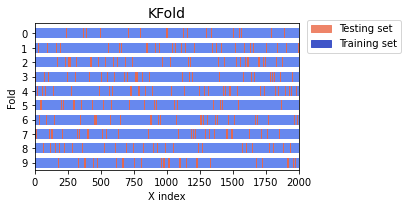

In [9]:
#code regarding KFold is taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
count = 0
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=26)

print("fold sizes:")
for i, (train_index, test_index) in enumerate(kf.split(X_local, Y_local)):
    print(f'Fold:{count}, Train set: {len(train_index)}, \
    Test set:{len(test_index)}')
    count += 1
print()

#code for k-fold split visualization obtained from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
#plot k-fold splits

print("Plotted folds:")

def plot_kfold(cv, X, y, ax, n_splits, xlim_max=100):
    """
    Plots the indices for a cross-validation object.

    Parameters:
    cv: Cross-validation object
    X: Feature set
    y: Target variable
    ax: Matplotlib axis object
    n_splits: Number of folds in the cross-validation
    xlim_max: Maximum limit for the x-axis
    """
    
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
    
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
        
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)

    # Set y-ticks and labels
    y_ticks = np.arange(n_splits) + 0.5
    ax.set(yticks=y_ticks, yticklabels=range(n_splits),
           xlabel="X index", ylabel="Fold",
           ylim=[n_splits, -0.2], xlim=[0, xlim_max])

    # Set plot title and create legend
    ax.set_title("KFold", fontsize=14)
    legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"),
                      Patch(color=cmap_cv(0.02), label="Training set")]
    ax.legend(handles=legend_patches, loc=(1.03, 0.8))

fig, ax = plt.subplots(figsize=(6, 3))
plot_kfold(kf, X_local, Y_local, ax, n_splits, xlim_max=2000)
# Make the legend fit
plt.tight_layout()
fig.subplots_adjust(right=0.7)
plt.savefig("KFold.jpg")

In [5]:
# from sklearn.pipeline import make_pipeline

# def train_model(X,y,folds,model):
#     pipeline = make_pipeline(StandardScaler(), model)
#     rmse_scores = []
#     r2_scores = []
#     for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
#         X_train,X_valid = X[train_index],X[valid_index]
#         y_train,y_valid = y[train_index],y[valid_index]
#         pipeline.fit(X_train, y_train)
#         y_pred = pipeline.predict(X_valid)
#         rmse_scores.append(root_mean_squared_error(y_valid, y_pred))
#         r2_scores.append(r2_score(y_valid, y_pred))
    
#     print('CV RMSE mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(rmse_scores), np.std(rmse_scores)))
#     print('CV R2 mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(r2_scores), np.std(r2_scores)))


In [6]:
#code for model usage adapted from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
#taking knowledge from Venkatachalam on Stack Overflow: https://stackoverflow.com/a/55469136
#setup KFold and model usage

# def cross_validation(reg_model, local_prepared, local_labels, cv, skip_imp=False):
#     scores = cross_validate(
#       reg_model, local_prepared,
#       local_labels,
#       scoring=("neg_root_mean_squared_error", 'r2'), 
#       cv=cv,
#       return_estimator=True)
#     print(scores)
#     print(scores.keys())
#     print("RMSE results:")
#     print("Scores:", scores["test_neg_root_mean_squared_error"])
#     print("Mean:", scores["test_neg_root_mean_squared_error"].mean())
#     print("StandardDeviation:", scores["test_neg_root_mean_squared_error"].std())
#     print()
#     print("R2 results")
#     print("Scores:", scores["test_r2"])
#     print("Mean:", scores["test_r2"].mean())
#     print("StandardDeviation:", scores["test_r2"].std())
    
    
#     for idx,estimator in enumerate(scores['estimator']):
#       print("Features sorted by their score for estimator {}:".format(idx))
#       if skip_imp:
#          continue
#       else:
#         feature_importances = pd.DataFrame(estimator.feature_importances_,
#                                        index = X_local.columns()[0],
#                                         columns=['importance']).sort_values('importance', ascending=False)
#         print(feature_importances)

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_local)

In [10]:
results_tracker = {}

In [15]:
#code for model creation adapted from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
#calling models and using with k-fold cross-validation
print("----- Linear Regression Model Cross Validation ------")
lin_reg = LinearRegression()
scores = cross_validate(
    lin_reg, X_scaled,
    Y_local,
    scoring=("neg_root_mean_squared_error", 'r2'), 
    cv=kf,
    return_estimator=True,
    verbose=4)

print(scores)
print(scores.keys())
print()
print("RMSE results:")
print("Scores:", scores["test_neg_root_mean_squared_error"])
print("Mean:", scores["test_neg_root_mean_squared_error"].mean())
print("StandardDeviation:", scores["test_neg_root_mean_squared_error"].std())
print()

print("R2 results")
print("Scores:", scores["test_r2"])
print("Mean:", scores["test_r2"].mean())
print("StandardDeviation:", scores["test_r2"].std())

results_tracker["1"] = [scores["test_neg_root_mean_squared_error"].mean(), scores["test_r2"].mean()]

----- Linear Regression Model Cross Validation ------
[CV] END  neg_root_mean_squared_error: (test=-98373.395) r2: (test=0.013) total time=   0.0s
[CV] END  neg_root_mean_squared_error: (test=-81873.109) r2: (test=0.016) total time=   0.0s
[CV] END  neg_root_mean_squared_error: (test=-99854.698) r2: (test=0.009) total time=   0.0s
[CV] END  neg_root_mean_squared_error: (test=-89839.454) r2: (test=0.017) total time=   0.0s
[CV] END  neg_root_mean_squared_error: (test=-105304.878) r2: (test=0.010) total time=   0.0s
[CV] END  neg_root_mean_squared_error: (test=-117723.682) r2: (test=0.015) total time=   0.0s
[CV] END  neg_root_mean_squared_error: (test=-91685.083) r2: (test=0.011) total time=   0.0s
[CV] END  neg_root_mean_squared_error: (test=-106366.923) r2: (test=0.013) total time=   0.0s
[CV] END  neg_root_mean_squared_error: (test=-75831.405) r2: (test=0.014) total time=   0.0s
[CV] END  neg_root_mean_squared_error: (test=-75079.815) r2: (test=0.022) total time=   0.0s
{'fit_time': 

In [16]:
print(results_tracker)

{'1': [-94193.2443218898, 0.013880328210706139], '2': [-94016.60919461295, 0.017591850321355795]}


In [19]:
print("----- Decision Tree Regression Model Cross Validation ------")
tree_reg = DecisionTreeRegressor(random_state=26)
scores = cross_validate(
    tree_reg, X_scaled,
    Y_local,
    scoring=("neg_root_mean_squared_error", 'r2'), 
    cv=kf,
    return_estimator=True)

print(scores)
print(scores.keys())
print("RMSE results:")
print("Scores:", scores["test_neg_root_mean_squared_error"])
print("Mean:", scores["test_neg_root_mean_squared_error"].mean())
print("StandardDeviation:", scores["test_neg_root_mean_squared_error"].std())
print()
print("R2 results")
print("Scores:", scores["test_r2"])
print("Mean:", scores["test_r2"].mean())
print("StandardDeviation:", scores["test_r2"].std())

results_tracker["2"] = [scores["test_neg_root_mean_squared_error"].mean(), scores["test_r2"].mean()]

----- Decision Tree Regression Model Cross Validation ------
{'fit_time': array([0.10576415, 0.05588508, 0.0561893 , 0.0539515 , 0.05336046,
       0.05797195, 0.05197573, 0.05824137, 0.04714274, 0.05037546]), 'score_time': array([0.01072621, 0.00235415, 0.00203824, 0.002285  , 0.00299382,
       0.00100136, 0.00199628, 0.00099659, 0.00263619, 0.00218511]), 'estimator': [DecisionTreeRegressor(random_state=26), DecisionTreeRegressor(random_state=26), DecisionTreeRegressor(random_state=26), DecisionTreeRegressor(random_state=26), DecisionTreeRegressor(random_state=26), DecisionTreeRegressor(random_state=26), DecisionTreeRegressor(random_state=26), DecisionTreeRegressor(random_state=26), DecisionTreeRegressor(random_state=26), DecisionTreeRegressor(random_state=26)], 'test_neg_root_mean_squared_error': array([ -98177.08469375,  -81999.58390126,  -99788.8188165 ,
        -89630.96129985, -105054.44648155, -117572.44323952,
        -91281.01958474, -106154.33254454,  -75497.27200051,
      

KeyError: 'x'

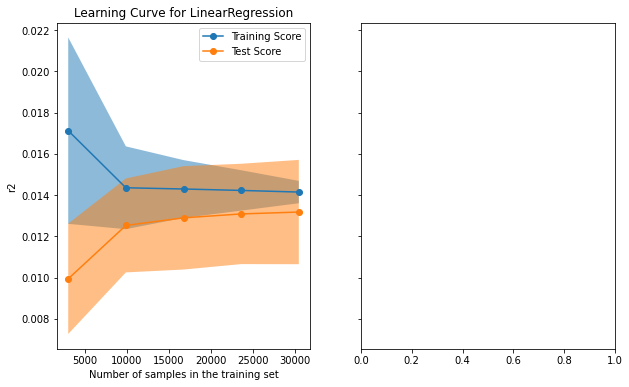

In [24]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6), sharey=True)

common_params = {
    "X": X_scaled,
    "y": Y_local,
    "train_sizes": np.linspace(0.1, 1.0, 5),
    "cv": ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    "score_type": "both",
    "n_jobs": 4,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "score_name": "r2",
}

for ax_idx, estimator in enumerate([lin_reg, tree_reg]):
    LearningCurveDisplay.from_estimator(estimator, **common_params, ax=ax[ax_idx])
    handles, label = ax[ax_idx].get_legend_handles_labels()
    ax[ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[ax_idx].set_title(f"Learning Curve for {estimator.__class__.__name__}")

plt.savefig("regression_learning_curves.jpg")

In [21]:
print("----- Random Forest Regression Model Cross Validation ------")
forest_reg = RandomForestRegressor()
# cross_validation(forest_reg, X_scaler, Y_local, kf)
# print("")

scores = cross_validate(
    forest_reg, X_scaled,
    Y_local,
    scoring=("neg_root_mean_squared_error", 'r2'), 
    cv=kf,
    return_estimator=True)

print(scores)
print(scores.keys())
print()
print("RMSE results:")
print("Scores:", scores["test_neg_root_mean_squared_error"])
print("Mean:", scores["test_neg_root_mean_squared_error"].mean())
print("StandardDeviation:", scores["test_neg_root_mean_squared_error"].std())
print()

print("R2 results")
print("Scores:", scores["test_r2"])
print("Mean:", scores["test_r2"].mean())
print("StandardDeviation:", scores["test_r2"].std())

results_tracker["3"] = [scores["test_neg_root_mean_squared_error"].mean(), scores["test_r2"].mean()]

----- Random Forest Regression Model Cross Validation ------
{'fit_time': array([3.32743573, 3.39806604, 3.29643822, 3.896492  , 3.48062301,
       3.49410963, 3.65649199, 3.43084311, 3.48735881, 3.40284371]), 'score_time': array([0.02952814, 0.02718449, 0.02768373, 0.03207803, 0.02784824,
       0.0279181 , 0.03532195, 0.02784348, 0.02877736, 0.02895451]), 'estimator': [RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor(), RandomForestRegressor()], 'test_neg_root_mean_squared_error': array([ -98174.57450332,  -81993.58429117,  -99781.62487849,
        -89628.5776485 , -105065.43494338, -117569.10620081,
        -91283.63314769, -106150.36902904,  -75484.27467416,
        -75001.97069593]), 'test_r2': array([0.01660162, 0.01264227, 0.00998039, 0.02209867, 0.0149408 ,
       0.01749939, 0.01939543, 0.01707982, 0.022722

In [22]:
print("----- K Nearest Neighbors Regression Model Cross Validation ------")
knn_reg = KNeighborsRegressor(n_neighbors=20, weights='distance')
# cross_validation(knn_reg, X_scaler, Y_local, kf)
# print("")
scores = cross_validate(
    knn_reg, X_scaled,
    Y_local,
    scoring=("neg_root_mean_squared_error", 'r2'), 
    cv=kf,
    return_estimator=True)

print(scores)
print(scores.keys())
print()
print("RMSE results:")
print("Scores:", scores["test_neg_root_mean_squared_error"])
print("Mean:", scores["test_neg_root_mean_squared_error"].mean())
print("StandardDeviation:", scores["test_neg_root_mean_squared_error"].std())
print()

print("R2 results")
print("Scores:", scores["test_r2"])
print("Mean:", scores["test_r2"].mean())
print("StandardDeviation:", scores["test_r2"].std())

results_tracker["4"] = [scores["test_neg_root_mean_squared_error"].mean(), scores["test_r2"].mean()]

----- K Nearest Neighbors Regression Model Cross Validation ------
{'fit_time': array([0.00974822, 0.00349426, 0.00643778, 0.00818539, 0.00351191,
       0.00552773, 0.00410223, 0.00548768, 0.00411201, 0.00686407]), 'score_time': array([0.66785765, 0.23143291, 0.22591519, 0.22813296, 0.21968079,
       0.22085977, 0.21383905, 0.24083304, 0.24830604, 0.22956991]), 'estimator': [KNeighborsRegressor(n_neighbors=20, weights='distance'), KNeighborsRegressor(n_neighbors=20, weights='distance'), KNeighborsRegressor(n_neighbors=20, weights='distance'), KNeighborsRegressor(n_neighbors=20, weights='distance'), KNeighborsRegressor(n_neighbors=20, weights='distance'), KNeighborsRegressor(n_neighbors=20, weights='distance'), KNeighborsRegressor(n_neighbors=20, weights='distance'), KNeighborsRegressor(n_neighbors=20, weights='distance'), KNeighborsRegressor(n_neighbors=20, weights='distance'), KNeighborsRegressor(n_neighbors=20, weights='distance')], 'test_neg_root_mean_squared_error': array([-10496

In [28]:
df_reg_scores = pd.DataFrame.from_dict(results_tracker)
df_reg_scores = df_reg_scores.T
df_reg_scores = df_reg_scores.rename(columns={1: "RMSE", 0: "R2"})
print(df_reg_scores)

df_reg_scores.to_csv("regression_scores_1.csv")

              R2      RMSE
1  -94193.244322  0.013880
2  -94016.609195  0.017592
3  -94013.315001  0.017672
4 -102327.857047 -0.174344


In [43]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
svm_reg = svm.SVR()

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, Y_local, test_size=0.33, random_state=42)
svm_reg.fit(X_train, y_train)
y_pred = svm_reg.predict(X_test)
print(r2_score(y_test, y_pred))

# scores = cross_validate(
#     knn_reg, X_scaler,
#     Y_local,
#     scoring=("neg_root_mean_squared_error"), 
#     cv=kf,
#     return_estimator=True)
# print(scores)
# print(scores.keys())

# print()
# print("RMSE results:")
# print("Scores:", scores["test_neg_root_mean_squared_error"])
# print("Mean:", scores["test_neg_root_mean_squared_error"].mean())
# print("StandardDeviation:", scores["test_neg_root_mean_squared_error"].std())
# print()

# print("R2 results")
# print("Scores:", scores["test_r2"])
# print("Mean:", scores["test_r2"].mean())
# print("StandardDeviation:", scores["test_r2"].std())

-0.03541591932953825


In [ ]:
print("----- Extreme Gradient Boost Regression Model Cross Validation ------")
xgb_reg = xgb
cross_validation(xgb_reg, X_scaler, Y_local, kf)